In [1]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import sax
import skrf
from skrf.frequency import Frequency
import warnings
from simphony.libraries.siepic import _resolve_source_filepath
from simphony.utils import wl2freq, freq2wl
from simphony.plugins.lumerical import load_sparams
from itertools import product
from functools import lru_cache, partial
import pandas as pd
from scipy.constants import c as SPEED_OF_LIGHT
import re

In [4]:
def coupler(coupling=0.5) -> sax.SDict:
    kappa = coupling ** 0.5
    tau = (1 - coupling) ** 0.5
    coupler_dict = sax.reciprocal(
        {
            ("in0", "out0"): tau,
            ("in0", "out1"): 1j * kappa,
            ("in1", "out0"): 1j * kappa,
            ("in1", "out1"): tau,
        }
    )
    return coupler_dict


coupler(coupling=0.3)

{('in0', 'out0'): 0.8366600265340756,
 ('in0', 'out1'): 0.5477225575051661j,
 ('in1', 'out0'): 0.5477225575051661j,
 ('in1', 'out1'): 0.8366600265340756,
 ('out0', 'in0'): 0.8366600265340756,
 ('out1', 'in0'): 0.5477225575051661j,
 ('out0', 'in1'): 0.5477225575051661j,
 ('out1', 'in1'): 0.8366600265340756}

In [5]:
def waveguide(wl=1.55, wl0=1.55, neff=2.34, ng=3.4, length=10.0, loss=0.0) -> sax.SDict:
    dwl = wl - wl0
    dneff_dwl = (ng - neff) / wl0
    neff = neff - dwl * dneff_dwl
    phase = 2 * jnp.pi * neff * length / wl
    transmission = 10 ** (-loss * length / 20) * jnp.exp(1j * phase)
    sdict = sax.reciprocal(
        {
            ("in0", "out0"): transmission,
        }
    )
    return sdict

# SiEPIC models

In [2]:
load_sparams_cached = lru_cache(maxsize=128)(load_sparams)

In [3]:
wl = jnp.linspace(1.51, 1.59, 100)

## Grating coupler

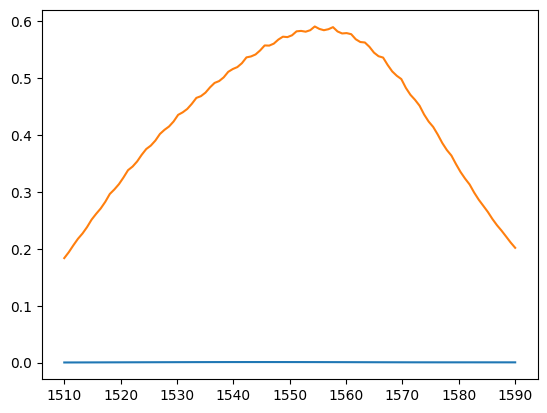

In [5]:
# @partial(jit, static_argnames=['pol', 'thickness', 'dwidth'])
def GC(wl=1.55, pol="te", thickness=220.0, dwidth=0) -> sax.SDict:
    """
    Parameters
    ----------
    wl : float or Array
        The wavelengths to evaluate at in microns.
    pol : {"te", "tm"}
        Polarization of the input/output modes.
    thickness : {210.0, 220.0, 230.0}
        Thickness of the GC in nm.
    dwidth : {-20.0, 0.0, 20.0}
        Width of the GC in nm.
    """
    if pol not in ["te", "tm"]:
        raise ValueError("'pol' must be either 'te' or 'tm'")
    pol = pol.upper()

    if thickness not in [210.0, 220.0, 230.0]:
        raise ValueError("'thickness' must be one of 210.0, 220.0, or 230")
    thickness = str(int(thickness))

    if dwidth not in [-20.0, 0.0, 20.0]:
        raise ValueError("'dwidth' must be one of -20, 0, or 20")
    dwidth = str(int(dwidth))

    _datafile = f"gc_source/GC_{pol}1550_thickness={thickness} deltaw={dwidth}.txt"
    path = _resolve_source_filepath(_datafile)
    arr = np.loadtxt(path)

    f = arr[:, 0]
    wl_arr = freq2wl(f)
    s11 = arr[:, 1] * np.exp(1j * arr[:, 2])
    s12 = arr[:, 3] * np.exp(1j * arr[:, 4])
    s21 = arr[:, 5] * np.exp(1j * arr[:, 6])
    s22 = arr[:, 7] * np.exp(1j * arr[:, 8])
    
    wl_m = wl * 1e-6
    s11 = jnp.interp(wl_m, wl_arr, s11.real) + 1j * jnp.interp(wl_m, wl_arr, s11.imag)
    s12 = jnp.interp(wl_m, wl_arr, s12.real) + 1j * jnp.interp(wl_m, wl_arr, s12.imag)
    s21 = jnp.interp(wl_m, wl_arr, s21.real) + 1j * jnp.interp(wl_m, wl_arr, s21.imag)
    s22 = jnp.interp(wl_m, wl_arr, s22.real) + 1j * jnp.interp(wl_m, wl_arr, s22.imag)
    
    sdict = {
        ("o0", "o0"): s11,
        ("o0", "o1"): s12,
        ("o1", "o0"): s21,
        ("o1", "o1"): s22,
    }

    return sdict

gc = GC(wl=wl)
plt.plot(1e3*wl, jnp.abs(gc['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(gc['o0', 'o1'])**2, label="in0->out0")

In [6]:
def GC_fixed(wl=1.55):
    return GC(wl=wl, pol="te", thickness=220.0, dwidth=0)

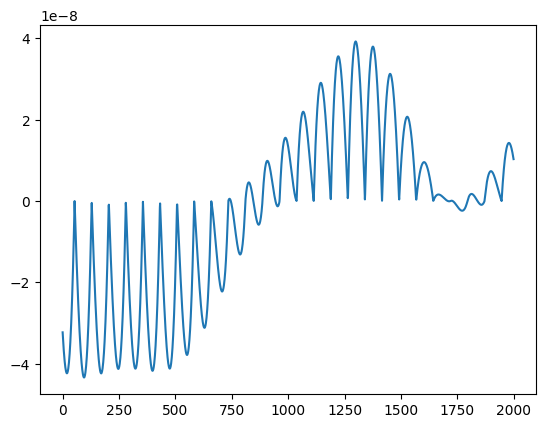

In [197]:
plt.plot(abs(gc['o0', 'o0'])**2 - abs(gc_old['o0', 'o0'])**2)

## Y Branch

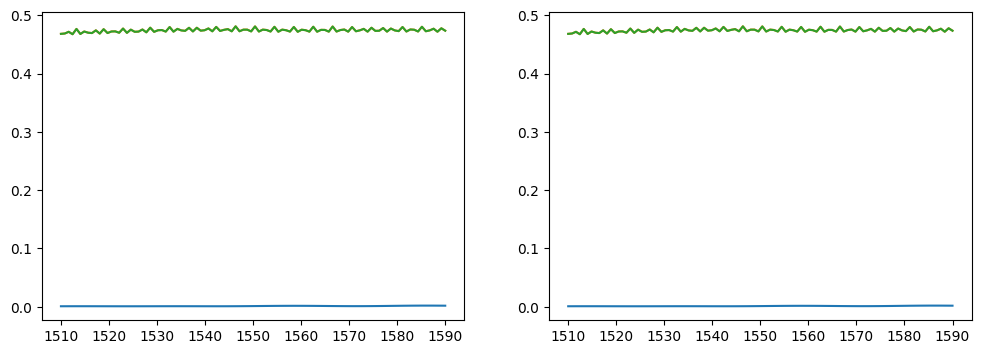

In [8]:
# @partial(jit, static_argnames=['pol', 'thickness', 'width'])
def Y(wl=1.55, pol="te", thickness=220.0, width=500) -> sax.SDict:
    if pol not in ["te", "tm"]:
        raise ValueError("'pol' must be one of 'te' or 'tm'")

    if thickness not in [210.0, 220.0, 230.0]:
        raise ValueError("'thickness' must be one of 210, 220, or 230")
    thickness = str(int(thickness))

    if width not in [480.0, 500.0, 520.0]:
        raise ValueError("'width' must be one of 480, 500, or 520")
    width = str(int(width))

    _datafile = f"y_branch_source/Ybranch_Thickness ={thickness} width={width}.sparam"

    file = _resolve_source_filepath(_datafile)
    header, data = load_sparams_cached(file)

    _POL_MAPPING = {"te": 1, "tm": 2}
    MODE_ID = _POL_MAPPING[pol]

    wl_m = jnp.array(wl).reshape(-1) * 1e-6  # convert microns to meters for skrf

    # Build the s-matrix
    f = None
    sdict = {}
    for (p_out, p_in), sdf in data[data.mode_out == MODE_ID].groupby(["port_out", "port_in"]):
        freq = sdf["freq"].values
        if f is None:
            f = freq
        else:
            if not np.allclose(f, freq):
                raise ValueError("Frequency mismatch between arrays in datafile.")
        sdf["wl"] = freq2wl(f)
        sdf.sort_values("wl", inplace=True)
        wl_act = sdf["wl"].values
        
        snn = sdf["mag"].values * np.exp(1j * sdf["phase"].values)
        sdict[(f"o{p_in-1}", f"o{p_out-1}")] = jnp.interp(wl_m, wl_act, snn.real) + 1j * jnp.interp(wl_m, wl_act, snn.imag)

    return sdict

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

plt.sca(axs[0])
y = Y(wl=wl)
plt.plot(1e3*wl, jnp.abs(y['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(y['o0', 'o1'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(y['o0', 'o2'])**2, label="in0->out0")

plt.sca(axs[1])
from simphony.libraries.siepic import YBranch
ys = YBranch()
s = ys.s_params(wl)
plt.plot(1e3*wl, jnp.abs(s[:,0,0])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(s[:,1,0])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(s[:,2,0])**2, label="in0->out0")

In [9]:
def Y_fixed(wl=1.55):
    return Y(wl=wl, pol="te", thickness=220.0, width=500)

In [302]:
%timeit y = Y_old(wl=wl)
%timeit y = Y(wl=wl)
%timeit y = Y(wl=wl)

10 ms ± 553 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
542 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
574 µs ± 68.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [300]:
ys = YBranch()
%timeit ys.s_params(wl)

160 ms ± 13.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [303]:
%timeit Y(wl=wl)
%timeit ys = YBranch(); ys.s_params(wl)

533 µs ± 48 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
175 ms ± 4.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
wl_immut = tuple(np.array(wl))

%timeit Y(wl=wl)
%timeit ys.s_params(wl)
%timeit ys._s(wl_immut)

1.81 ms ± 82.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
26.4 ms ± 585 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.13 µs ± 26.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## Waveguide

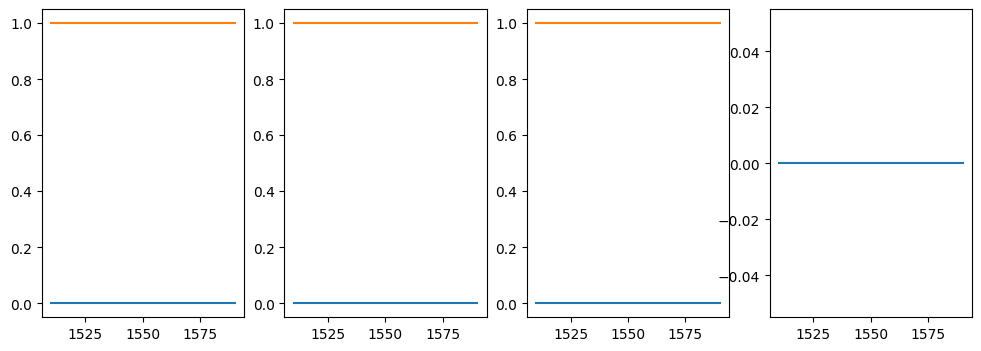

In [11]:
# @partial(jit, static_argnames=['pol', 'length', 'width', 'height'])
def WG(
    wl=1.55,
    pol="te",
    length=0,
    width=500,
    height=220,
    loss=0,
) -> sax.SDict:
    if pol not in ["te", "tm"]:
        raise ValueError("Invalid polarization, must be either 'te' or 'tm'")
    
    width, height = int(width), int(height)

    _datafile = f"wg_integral_source/WaveGuideTETMStrip,w={width},h={height}.txt"

    # Load data file, extract coefficients
    path = _resolve_source_filepath(_datafile)
    arr = np.loadtxt(path)
    
    if pol == "te":
        lam0, ne, _, ng, _, nd, _ = arr
    else:  # tm
        lam0, _, ne, _, ng, _, nd = arr

    wl_m = jnp.asarray(wl).reshape(-1) * 1e-6  # convert microns to meters
    freqs = wl2freq(wl_m)  # convert wavelengths to freqs
    length_m = length * 1e-6  # convert microns to meters
    loss = loss * 100  # convert loss from dB/cm to dB/m

    # Loss calculation (convert loss to dB/m)
    alpha = loss / (20 * jnp.log10(jnp.exp(1)))
    omega = 2 * jnp.pi * jnp.asarray(freqs)  # get angular freqs from freqs
    omega0 = (2 * jnp.pi * SPEED_OF_LIGHT) / lam0  # center freqs (angular)

    # calculation of K
    K = (
        2 * jnp.pi * ne / lam0
        + (ng / SPEED_OF_LIGHT) * (omega - omega0)
        - (nd * lam0**2 / (4 * jnp.pi * SPEED_OF_LIGHT)) * ((omega - omega0) ** 2)
    )

    sdict = {
        ("o0", "o0"): jnp.zeros(wl_m.shape, dtype=np.complex128),
        ("o0", "o1"): jnp.exp(-alpha * length_m + (1j * K * length_m)),
        ("o1", "o0"): jnp.exp(-alpha * length_m + (1j * K * length_m)),
        ("o1", "o1"): jnp.zeros(wl_m.shape, dtype=np.complex128),
    }
    return sdict

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

plt.sca(axs[0])
wg = WG(wl=wl)
plt.plot(1e3*wl, jnp.abs(wg['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(wg['o0', 'o1'])**2, label="in0->out0")

plt.sca(axs[1])
from simphony.libraries.siepic import Waveguide
wg_simp = Waveguide()
s = wg_simp.s_params(wl)
plt.plot(1e3*wl, jnp.abs(s[:,0,0])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(s[:,1,0])**2, label="in0->out0")

plt.sca(axs[2])
wg_old = WG_old(wl=wl)
plt.plot(1e3*wl, jnp.abs(wg_old['o0', 'o0'])**2, label="in0->out0")
plt.plot(1e3*wl, jnp.abs(wg_old['o0', 'o1'])**2, label="in0->out0")

plt.sca(axs[3])
plt.plot(1e3*wl, jnp.abs(wg['o0', 'o1'])**2 - jnp.abs(wg_old['o0', 'o1'])**2)

In [12]:
def WG_fixed(wl=1.55, length=0):
    return WG(wl=wl, pol="te", length=length, width=500, height=220, loss=0)

In [315]:
%timeit wg = WG_old(wl=wl)
%timeit wg = WG(wl=wl)
%timeit wg = Waveguide().s_params(wl)

9.63 ms ± 629 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
30.5 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
9.7 ms ± 902 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Comparison to Simphony

In [13]:
import matplotlib.pyplot as plt
from simphony.libraries import siepic
from simphony.circuit import Circuit
from simphony.simulation import ClassicalSim

In [14]:
wl = jnp.linspace(1.51, 1.59, 2000)

/home/sequoia/git/simphony/env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/sequoia/git/simphony/env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn("scatter inputs have incompatible types: cannot safely cast "
/home/sequoia/git/simphony/env/lib/python3.11/site-packages/jax/_src/ops/scatter.py:94: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=complex128 to dtype=complex64 with jax_numpy_dtype_prom

104 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


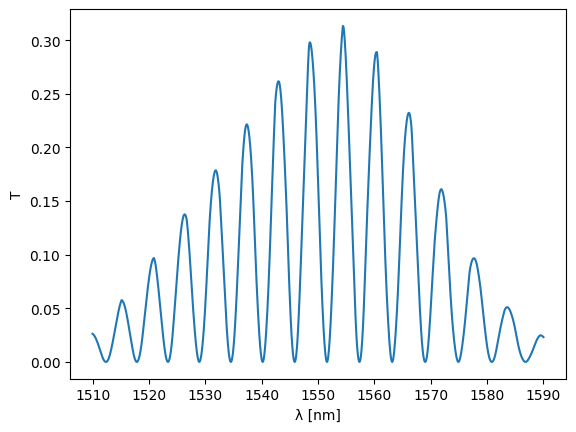

In [21]:
def simulate_mzi(wl):
    gc_input = siepic.GratingCoupler()
    y_splitter = siepic.YBranch()
    wg_long = siepic.Waveguide(length=150)
    wg_short = siepic.Waveguide(length=50)
    y_recombiner = siepic.YBranch()
    gc_output = siepic.GratingCoupler()

    ckt = Circuit()
    ckt.connect(gc_input.o(0), y_splitter.o(0))
    ckt.connect(y_splitter, [wg_short, wg_long])
    ckt.connect(gc_output.o(), y_recombiner)
    ckt.connect(y_recombiner, [wg_short, wg_long])

    return ckt.s_params(wl)

%timeit s = simulate_mzi(wl)
s = simulate_mzi(wl)

plt.plot(wl * 1e3, abs(s[:,1,0]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
plt.show()

In [16]:
def wg_150(wl=1.55):
    return WG_fixed(wl=wl, length=150)

def wg_50(wl=1.55):
    return WG_fixed(wl=wl, length=50)

7.54 ms ± 644 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
9.54 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


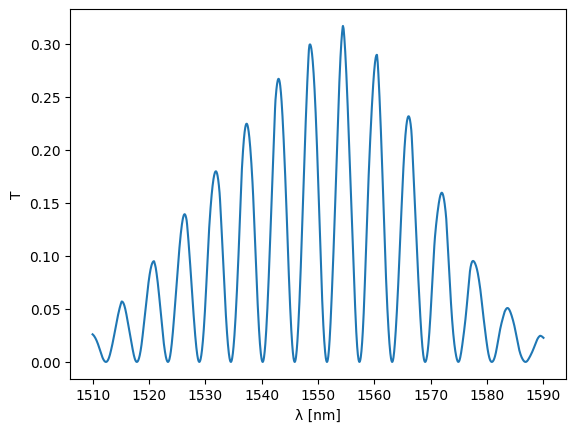

In [17]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "ingc": "gc",
            "lft": "ybranch",
            "top": "wg_long",
            "btm": "wg_short",
            "rgt": "ybranch",
            "outgc": "gc",
        },
        "connections": {
            "ingc,o1": "lft,o0",
            "lft,o1": "btm,o0",
            "btm,o1": "rgt,o1",
            "lft,o2": "top,o0",
            "top,o1": "rgt,o2",
            "rgt,o0": "outgc,o1",
        },
        "ports": {
            "in": "ingc,o0",
            "out": "outgc,o0",
        },
    },
    models={
        "ybranch": Y_fixed,
        # "wg_long": lambda wl: WG_fixed(wl=wl, length=150),
        # "wg_short": lambda wl: WG_fixed(wl=wl, length=50),
        "wg_long": wg_150,
        "wg_short": wg_50,
        "gc": GC_fixed,
    }
)

jitted_mzi = jit(mzi)
%timeit S = jitted_mzi(wl=wl)
%timeit S = jitted_mzi(wl=wl)
S = mzi(wl=wl)

plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

In [18]:
%timeit S = jitted_mzi(wl=wl)

9.06 ms ± 627 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


145 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


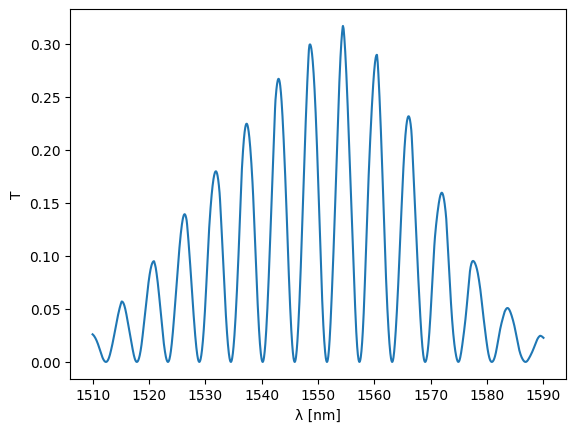

In [19]:
mzi, info = sax.circuit(
    netlist={
        "instances": {
            "ingc": "gc",
            "lft": "ybranch",
            "top": "waveguide",
            "btm": "waveguide",
            "rgt": "ybranch",
            "outgc": "gc",
        },
        "connections": {
            "ingc,o1": "lft,o0",
            "lft,o1": "btm,o0",
            "btm,o1": "rgt,o1",
            "lft,o2": "top,o0",
            "top,o1": "rgt,o2",
            "rgt,o0": "outgc,o1",
        },
        "ports": {
            "in": "ingc,o0",
            "out": "outgc,o0",
        },
    },
    models={
        "ybranch": Y,
        "waveguide": WG,
        "gc": GC,
    }
)

%timeit S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})
S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})

plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

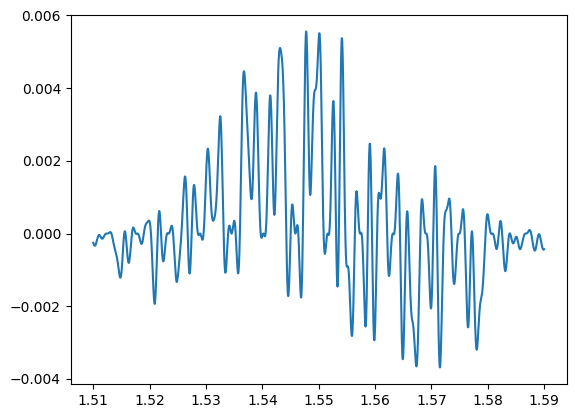

In [374]:
plt.plot(wl, abs(S["in", "out"]) ** 2 - abs(s[:,1,0]) ** 2)

# Subcircuits in Sax

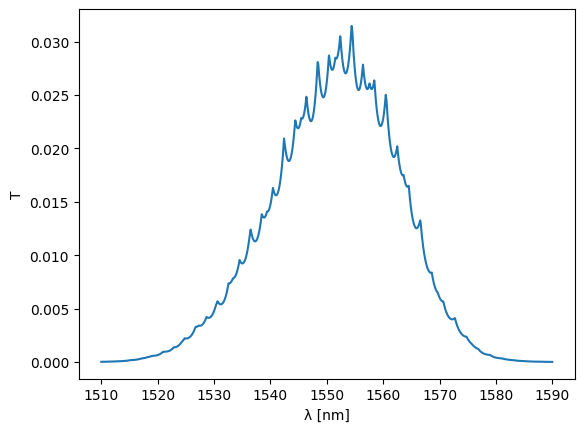

In [20]:
mzi_settings = {
    "top": {"length": 150.0},
    "btm": {"length": 50.0},
}

mzi_chain, info = sax.circuit(
    netlist={
        "instances": {
            "mzi1": mzi,
            "mzi2": mzi,
            "mzi3": mzi,
            # "mzi1": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
            # "mzi2": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
            # "mzi3": {
            #     "component": "mzi",
            #     "settings": mzi_settings,
            # },
        },
        "connections": {
            "mzi1,out": "mzi2,in",
            "mzi2,out": "mzi3,in",
        },
        "ports": {
            "in": "mzi1,in",
            "out": "mzi3,out",
        },
    },
    models={
        "mzi": partial(mzi, top={"length": 150.0}, btm={"length": 50.0}),
        # "mzi": mzi,
    }
)

version = 0
match version:
    case 0:
        S = mzi_chain(
            wl=wl, 
        )
    case 1:
        S = mzi_chain(
            wl=wl, 
            mzi1={"top": {"length": 150.0}, "btm": {"length": 50.0}}, 
            mzi2={"top": {"length": 150.0}, "btm": {"length": 50.0}}, 
            mzi3={"top": {"length": 150.0}, "btm": {"length": 50.0}}
        )
    case 2:
        S = mzi_chain(wl=wl)


plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
plt.xlabel("λ [nm]")
plt.ylabel("T")
# plt.ylim(-0.05, 1.05)
plt.show()

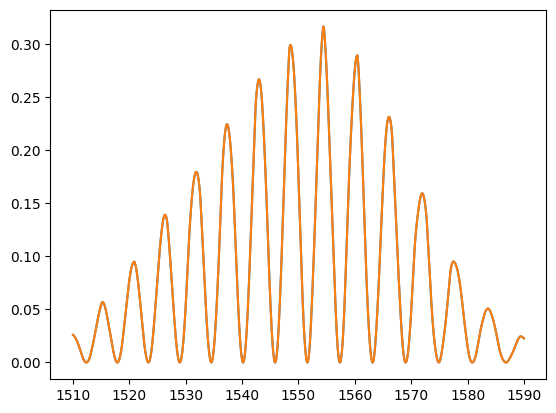

In [161]:
S = partial(mzi, top={"length": 150.0}, btm={"length": 50.0})(wl=wl)
plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)
S = mzi(wl=wl, top={"length": 150.0}, btm={"length": 50.0})
plt.plot(wl * 1e3, abs(S["in", "out"]) ** 2)

In [157]:
mzi?

Signature:
mzi(
    *,
    ingc={'pol': 'te', 'thickness': Array(220., dtype=float64), 'dwidth': Array(0., dtype=float64), 'wl': Array(1.55, dtype=float64)},
    lft={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'thickness': Array(220., dtype=float64), 'width': Array(500., dtype=float64)},
    top={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'length': Array(0., dtype=float64), 'width': Array(500., dtype=float64), 'height': Array(220., dtype=float64), 'loss': Array(0., dtype=float64), 'sigma_ne': Array(0.05, dtype=float64), 'sigma_ng': Array(0.05, dtype=float64), 'sigma_nd': Array(0.0001, dtype=float64)},
    btm={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'length': Array(0., dtype=float64), 'width': Array(500., dtype=float64), 'height': Array(220., dtype=float64), 'loss': Array(0., dtype=float64), 'sigma_ne': Array(0.05, dtype=float64), 'sigma_ng': Array(0.05, dtype=float64), 'sigma_nd': Array(0.0001, dtype=float64)},
    rgt={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'th

In [158]:
mzi_part = partial(mzi, top={"length": 150.0}, btm={"length": 50.0})
mzi_part?

Signature:     
mzi_part(
    *,
    ingc={'pol': 'te', 'thickness': Array(220., dtype=float64), 'dwidth': Array(0., dtype=float64), 'wl': Array(1.55, dtype=float64)},
    lft={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'thickness': Array(220., dtype=float64), 'width': Array(500., dtype=float64)},
    top={'length': 150.0},
    btm={'length': 50.0},
    rgt={'wl': Array(1.55, dtype=float64), 'pol': 'te', 'thickness': Array(220., dtype=float64), 'width': Array(500., dtype=float64)},
    outgc={'pol': 'te', 'thickness': Array(220., dtype=float64), 'dwidth': Array(0., dtype=float64), 'wl': Array(1.55, dtype=float64)},
) -> 'SType'
Call signature: mzi_part(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function _flat_circuit.<locals>._circuit at 0x7f9d1d356ca0>, top={'length': 150.0}, btm={'length': 50.0})
File:           /usr/lib/python3.11/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given ar

# Parameter sweeps/optimizations in Sax

In [159]:
# @jit
def somefunc(dl):
    S = mzi(wl=1.55, top={"length": 50.0+dl}, btm={"length": 50.0})
    return (abs(S["in", "out"]) ** 2).mean()

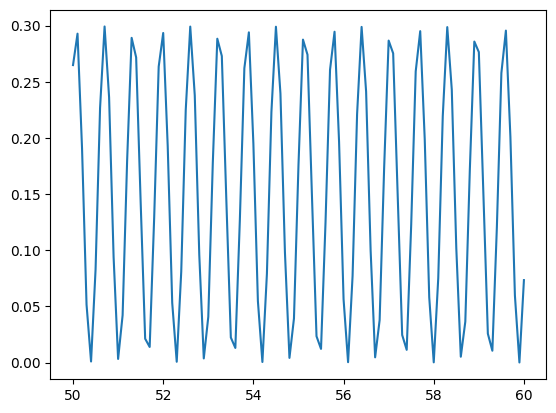

In [160]:
res = [(dl, somefunc(dl)) for dl in np.linspace(50,60,101)]
x, y = zip(*res)
plt.plot(x,y)